In [9]:
import numpy as np 
import pandas as pd

In [10]:
embs = np.load('data/embeddings/llama-3.1-70b-instruct-turbo/embeddings.npy')
metadata = pd.read_csv('data/embeddings/llama-3.1-70b-instruct-turbo/metadata.csv')

In [11]:
merge = metadata.merge(pd.DataFrame(embs), left_index=True, right_index=True)

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

group_similarities = {}

grouped = metadata.groupby(['story', 'language', 'suffix'])

for name, group in grouped:
    indices = group.index.values
    if len(indices) > 1:  # Only calculate if group has more than 1 element
        group_embs = embs[indices]
        # Calculate pairwise cosine similarities
        similarities = cosine_similarity(group_embs)
        # Get upper triangle values (excluding diagonal)
        upper_tri = similarities[np.triu_indices_from(similarities, k=1)]
        # Store average similarity
        group_similarities[name] = np.mean(upper_tri)

# Convert results to DataFrame
results = pd.DataFrame([
    {'story': k[0], 'language': k[1], 'suffix': k[2], 'avg_similarity': v}
    for k, v in group_similarities.items()
])

In [13]:
group_similarities = {}

grouped = metadata.groupby(['language','suffix'])

for name, group in grouped:
    indices = group.index.values
    if len(indices) > 1:  # Only calculate if group has more than 1 element
        group_embs = embs[indices]
        # Calculate pairwise cosine similarities
        similarities = cosine_similarity(group_embs)
        # Get upper triangle values (excluding diagonal)
        upper_tri = similarities[np.triu_indices_from(similarities, k=1)]
        # Store average similarity
        group_similarities[name] = np.mean(upper_tri)

# Convert results to DataFrame
results_full = pd.DataFrame([
    {'language': k[0], 'suffix': k[1], 'avg_similarity': v}
    for k, v in group_similarities.items()
])

In [15]:
results.groupby(['language', 'suffix'])['avg_similarity'].mean()

language  suffix
de        False     0.809424
          True      0.813848
en        False     0.812997
          True      0.790720
fr        False     0.821966
          True      0.810073
ru        False     0.679063
          True      0.683412
tr        False     0.670063
          True      0.665261
Name: avg_similarity, dtype: float64

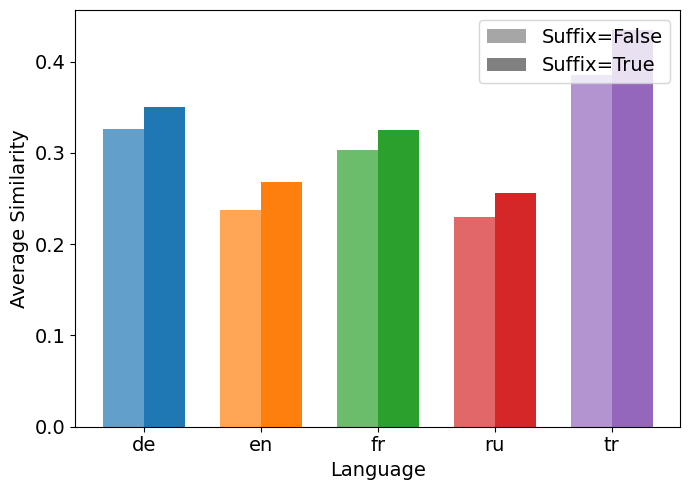

In [24]:
# Create the side-by-side bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))

# Get the data in the right format
plot_data = results_full.copy()
languages = plot_data['language'].unique()
x = np.arange(len(languages))
width = 0.35

# Colors for each language
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create bars
for i, lang in enumerate(languages):
    lang_data = plot_data[plot_data['language'] == lang]
    false_val = lang_data[lang_data['suffix'] == False]['avg_similarity'].values[0]
    true_val = lang_data[lang_data['suffix'] == True]['avg_similarity'].values[0]
    
    plt.bar(x[i] - width/2, false_val, width, color=colors[i], alpha=0.7, label=lang)
    plt.bar(x[i] + width/2, true_val, width, color=colors[i], alpha=1.0)

# Customize the plot
plt.xlabel('Language', fontsize=14)
plt.ylabel('Average Similarity', fontsize=14)
# plt.title('Average Similarities by Language and Suffix')
plt.xticks(x, languages, fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

# Add a custom legend for True/False
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=0.7, label='Suffix=False'),
    Patch(facecolor='gray', alpha=1.0, label='Suffix=True')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig('visuals/avg_similarity_by_language_and_suffix.pdf', dpi=300, bbox_inches='tight')
plt.show()
